
## Task 3 Part d)

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import librosa
import librosa.display
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
ANTHEM_AUDIO_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio"     # Folder containing anthem audio files
RESULTS_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_d"     # Folder to save results

In [28]:
#################################################################
# PART D: AUDIO ANALYSIS
#################################################################

def load_anthem_audio():
    """Load audio features for all anthem audio files."""
    audio_features = {}
    
    for file_path in glob.glob(os.path.join(ANTHEM_AUDIO_DIR, "*.mp3")):
        print("Processing audio file: ", file_path)
        try:
            country_name = os.path.basename(file_path).replace('.mp3', '')
            print("Processing", country_name)
            
            # Load audio file
            y, sr = librosa.load(file_path, sr=None)
            
            # Extract features
            # Tempo and beat information
            tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            
            # Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            
            # MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            
            # Chroma features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            
            # Extract summary statistics for each feature
            features = {
                'tempo': tempo,
                'spectral_centroid_mean': np.mean(spectral_centroids),
                'spectral_centroid_std': np.std(spectral_centroids),
                'spectral_rolloff_mean': np.mean(spectral_rolloff),
                'spectral_rolloff_std': np.std(spectral_rolloff),
            }
            
            # Add MFCC statistics
            for i in range(13):
                features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
                features[f'mfcc{i+1}_std'] = np.std(mfccs[i])
            
            # Add chroma statistics
            chroma_means = np.mean(chroma, axis=1)
            for i in range(12):
                features[f'chroma{i+1}'] = chroma_means[i]
            
            audio_features[country_name] = features
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    print(f"Loaded audio features for {len(audio_features)} anthems.")
    return audio_features


def analyze_anthem_audio(audio_features):
    """Perform analysis on audio features."""
    print("\n--- AUDIO ANALYSIS ---")
    
    if not audio_features:
        print("No audio features available for analysis.")
        return None
    
    # Convert to DataFrame
    audio_df = pd.DataFrame.from_dict(audio_features, orient='index')

    # Debug: Check data types and contents
    print("DataFrame info:")
    print(audio_df.info())
    
    print("\nDataFrame head:")
    print(audio_df.head())
    
    audio_df = audio_df.dropna(subset=['tempo'])  # Remove rows with NaN tempo
    
    print("\nTempo column dtype:", audio_df['tempo'].dtype)
    print("Tempo values:", audio_df['tempo'].tolist())

    print("Total number of countries:", len(audio_df))
    print("\nColumns with NaN values:")
    print(audio_df.isna().sum())
    
    # Verbose data type checking
    print("\nColumn data types:")
    print(audio_df.dtypes)
    
    # Ensure numeric conversion
    #audio_df['tempo'] = pd.to_numeric(audio_df['tempo'], errors='coerce')
    # tempo is an array of list, so we need to convert it to float
    audio_df['tempo'] = audio_df['tempo'].apply(lambda x: x[0])
    print("Audio df tempo: ",audio_df['tempo'])
    print("count nans in tempo",audio_df['tempo'].isna().sum())

    numeric_columns = audio_df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        audio_df[col] = pd.to_numeric(audio_df[col], errors='coerce')    
    # Basic statistics
    print("\nAudio feature statistics:")
    try: 
        print(f"Number of anthems analyzed: {len(audio_df)}")
        print(f"Average tempo: {audio_df['tempo'].mean():.2f} BPM")
        print(f"Tempo range: {audio_df['tempo'].min():.2f} - {audio_df['tempo'].max():.2f} BPM")
    except Exception as e:
        print(f"Error calculating tempo statistics: {e}")
        print("Tempo column contents:", audio_df['tempo'])

    # Find fastest and slowest anthems
    fastest = audio_df['tempo'].idxmax()
    slowest = audio_df['tempo'].idxmin()
    print(f"Fastest anthem: {fastest} ({audio_df.loc[fastest, 'tempo']:.2f} BPM)")
    print(f"Slowest anthem: {slowest} ({audio_df.loc[slowest, 'tempo']:.2f} BPM)")
    
    # Save audio features
    audio_df.to_csv(os.path.join(RESULTS_DIR, 'anthem_audio_features.csv'))
    
    # Correlation heatmap of audio features
    plt.figure(figsize=(12, 10))
    correlation = audio_df.corr()
    sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Between Audio Features')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'audio_correlation.png'))
    
    # PCA on audio features
    # Normalize features first
    audio_df_norm = (audio_df - audio_df.mean()) / audio_df.std()
    
    audio_df_norm = audio_df_norm.fillna(audio_df_norm.mean())

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(audio_df_norm)  # Handle any NaN values
    
    # Create PCA plot
    plt.figure(figsize=(12, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    
    # Add country labels
    for i, country in enumerate(audio_df.index):
        plt.annotate(country, (pca_result[i, 0], pca_result[i, 1]), 
                    fontsize=8, alpha=0.8)
    
    plt.title('PCA of National Anthem Audio Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'anthem_audio_pca.png'))
    
    # Clustering analysis
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(audio_df_norm.fillna(0))
    
    # Create a DataFrame with clustering results
    cluster_df = pd.DataFrame({
        'Country': audio_df.index,
        'Cluster': clusters
    })
    
    # Print clusters
    print("\nAnthem audio clusters:")
    for cluster_id in range(5):
        countries = cluster_df[cluster_df['Cluster'] == cluster_id]['Country'].tolist()
        print(f"Cluster {cluster_id}: {', '.join(countries[:5])}{'...' if len(countries) > 5 else ''}")
    
    # Save clustering results
    cluster_df.to_csv(os.path.join(RESULTS_DIR, 'anthem_audio_clusters.csv'), index=False)
    
    # Feature importance analysis
    print("\nMost influential audio features for each principal component:")
    feature_names = audio_df.columns
    for i, component in enumerate(pca.components_):
        sorted_idx = np.argsort(np.abs(component))[::-1]
        top_features = [(feature_names[idx], component[idx]) for idx in sorted_idx[:5]]
        print(f"PC{i+1}: {top_features}")
    
    return audio_df

In [10]:
 # Part D: Audio Analysis
audio_features = load_anthem_audio()
print("\n")
audio_features

Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\ad.mp3
Processing ad
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\ae.mp3
Processing ae
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\af.mp3
Processing af
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\ag.mp3
Processing ag
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\ai.mp3
Processing ai
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\al.mp3
Processing al
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\am.mp3
Processing am
Processing audio file:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\nationalanthems_audio\ao.mp3
Processing ao
Processing audio

{'ad': {'tempo': array([99.38401442]),
  'spectral_centroid_mean': 1670.7949337290327,
  'spectral_centroid_std': 833.4108517352894,
  'spectral_rolloff_mean': 3054.0901436307413,
  'spectral_rolloff_std': 1808.5357389149938,
  'mfcc1_mean': -271.76633,
  'mfcc1_std': 119.22792,
  'mfcc2_mean': 176.06476,
  'mfcc2_std': 48.100006,
  'mfcc3_mean': -31.66018,
  'mfcc3_std': 35.47621,
  'mfcc4_mean': 8.793731,
  'mfcc4_std': 28.281523,
  'mfcc5_mean': -9.32436,
  'mfcc5_std': 20.241968,
  'mfcc6_mean': 9.654454,
  'mfcc6_std': 14.750306,
  'mfcc7_mean': -3.8230832,
  'mfcc7_std': 11.474271,
  'mfcc8_mean': 1.1903102,
  'mfcc8_std': 9.867645,
  'mfcc9_mean': -5.4056106,
  'mfcc9_std': 9.977879,
  'mfcc10_mean': 0.4685378,
  'mfcc10_std': 9.036692,
  'mfcc11_mean': -5.2158146,
  'mfcc11_std': 6.984677,
  'mfcc12_mean': -3.4520466,
  'mfcc12_std': 7.0683517,
  'mfcc13_mean': -4.242979,
  'mfcc13_std': 7.468117,
  'chroma1': 0.22452213,
  'chroma2': 0.27195975,
  'chroma3': 0.47088444,
  'chr


--- AUDIO ANALYSIS ---
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, ad to zw
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tempo                   230 non-null    object 
 1   spectral_centroid_mean  230 non-null    float64
 2   spectral_centroid_std   230 non-null    float64
 3   spectral_rolloff_mean   230 non-null    float64
 4   spectral_rolloff_std    230 non-null    float64
 5   mfcc1_mean              230 non-null    float32
 6   mfcc1_std               230 non-null    float32
 7   mfcc2_mean              230 non-null    float32
 8   mfcc2_std               230 non-null    float32
 9   mfcc3_mean              230 non-null    float32
 10  mfcc3_std               230 non-null    float32
 11  mfcc4_mean              230 non-null    float32
 12  mfcc4_std               230 non-null    float32
 13  mfcc5_mean              230 non-null    float32
 14  mfcc5_s

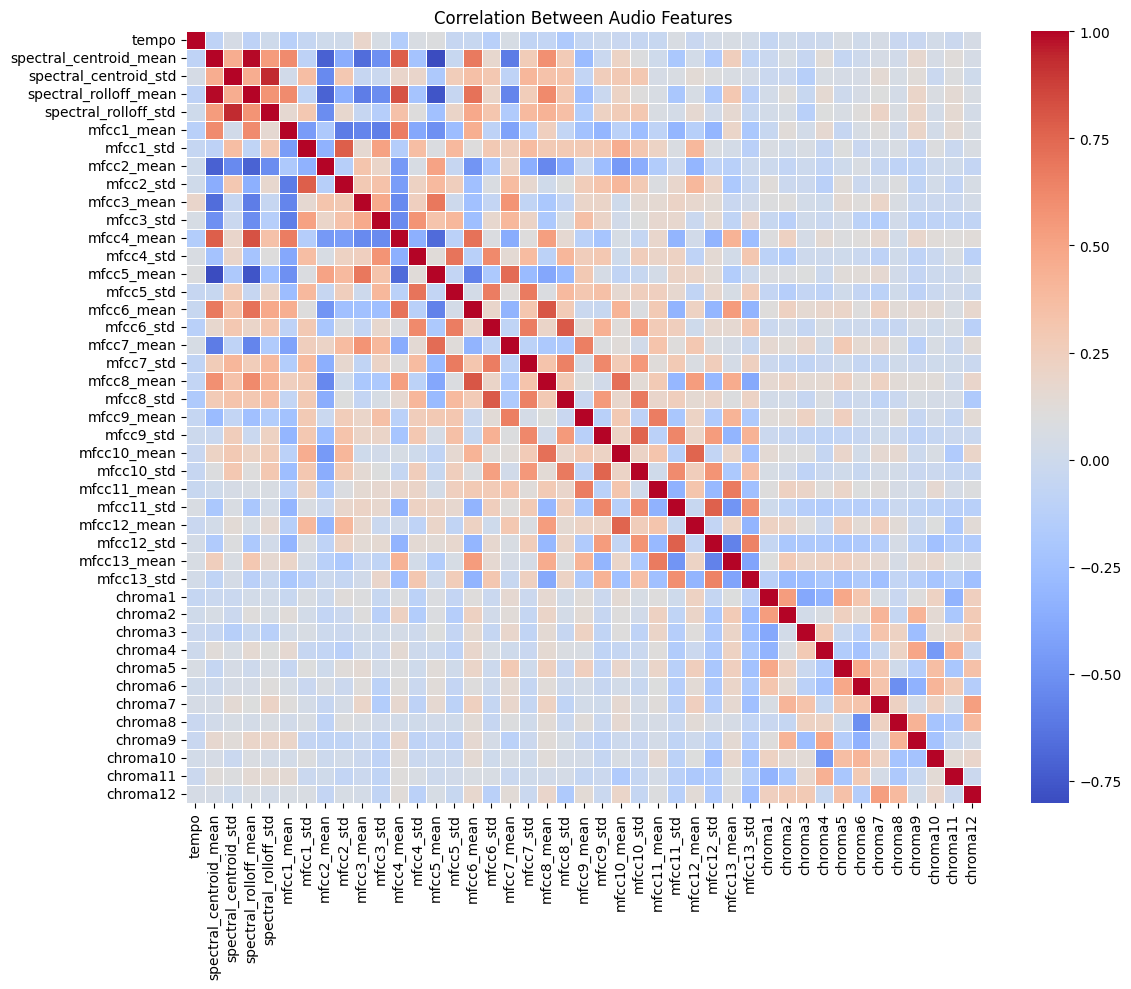

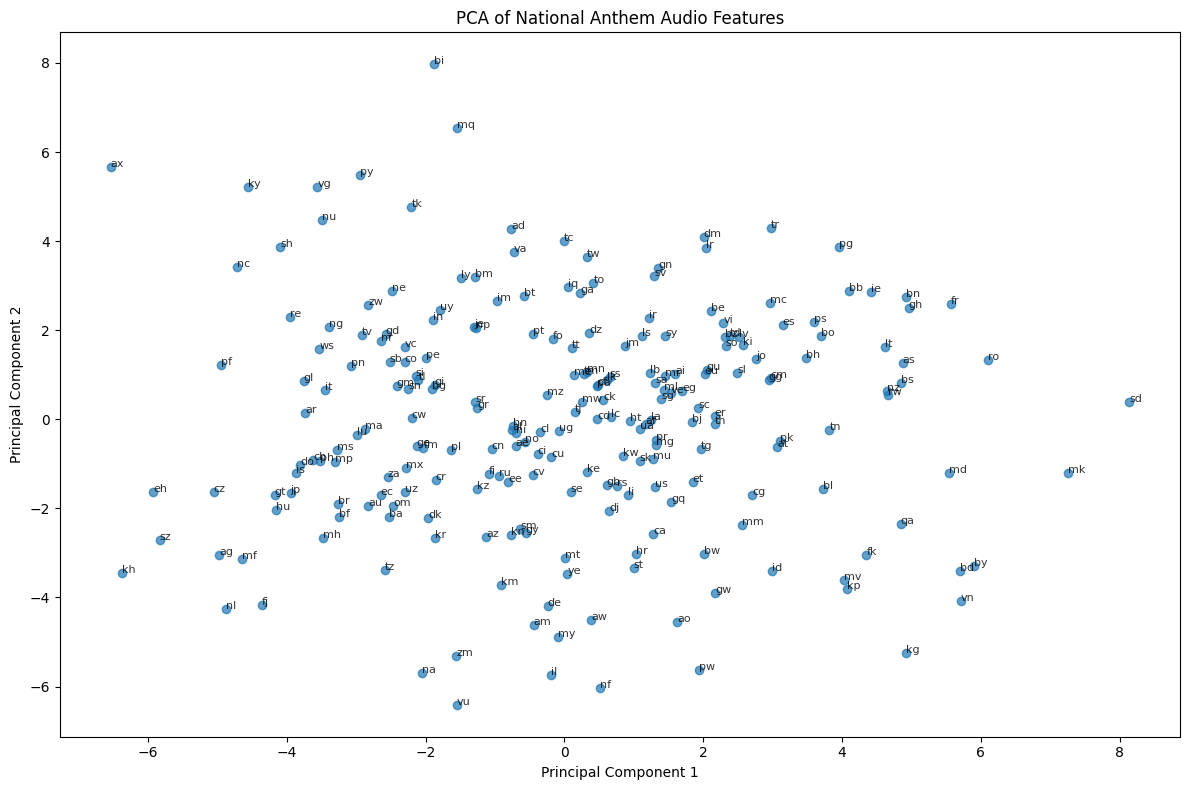

In [31]:
audio_df = analyze_anthem_audio(audio_features)
audio_df.to_csv('anthem_audio_features.csv')

## Plotting the audio clusters

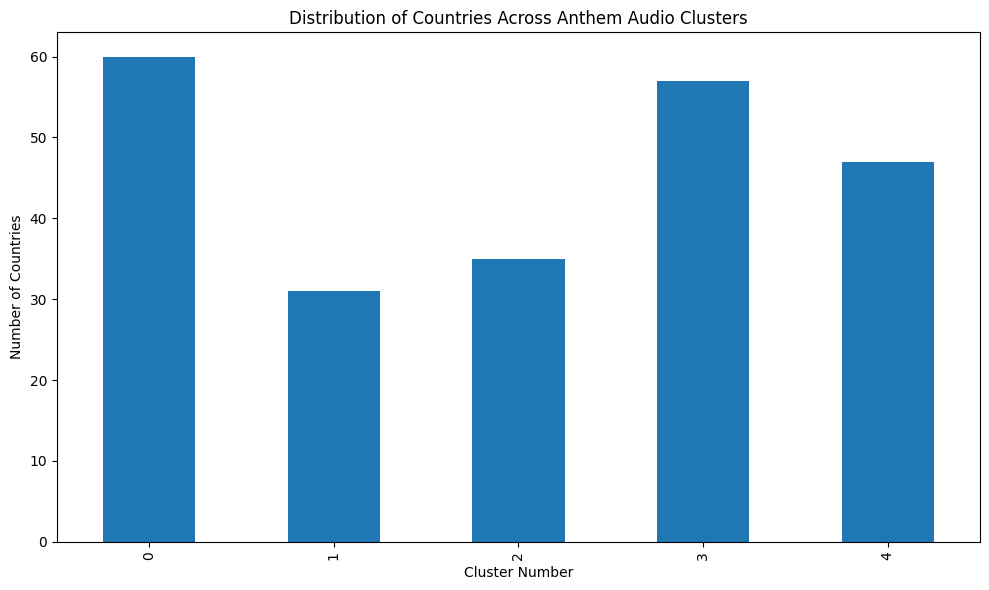

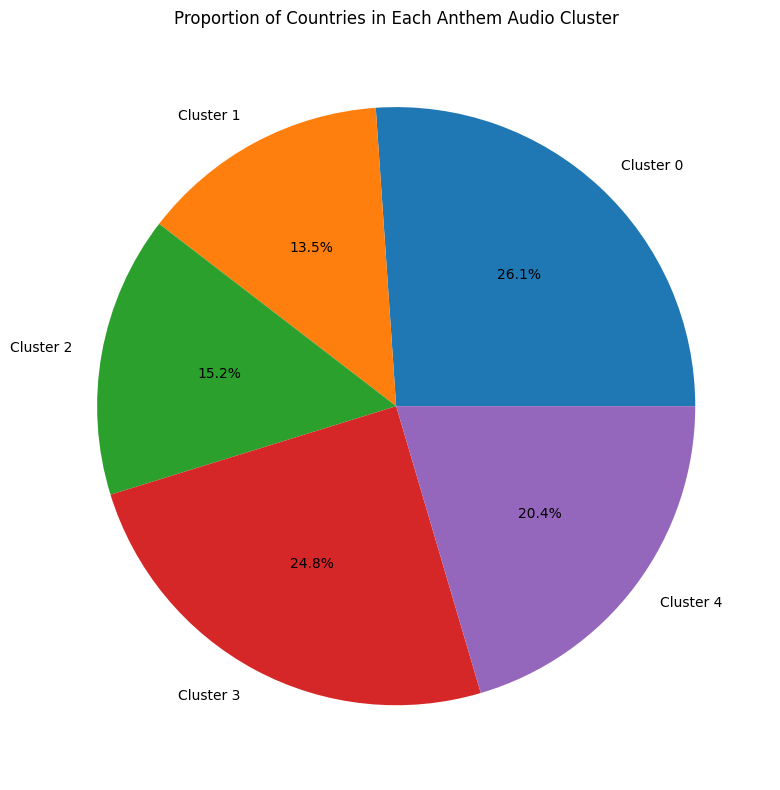

Cluster Analysis:

Cluster 0 (60 countries):
ae, af, al, am, ao, aw, bw, ca, cd, ci...

Cluster 1 (31 countries):
ad, ax, bg, bi, bm, bt, co, gd, in, iq...

Cluster 2 (35 countries):
as, at, bb, bd, bh, bj, bl, bn, bo, bs...

Cluster 3 (57 countries):
ag, ar, au, az, ba, bf, br, ch, cr, cw...

Cluster 4 (47 countries):
ai, be, bz, cf, dm, dz, eg, er, es, eu...


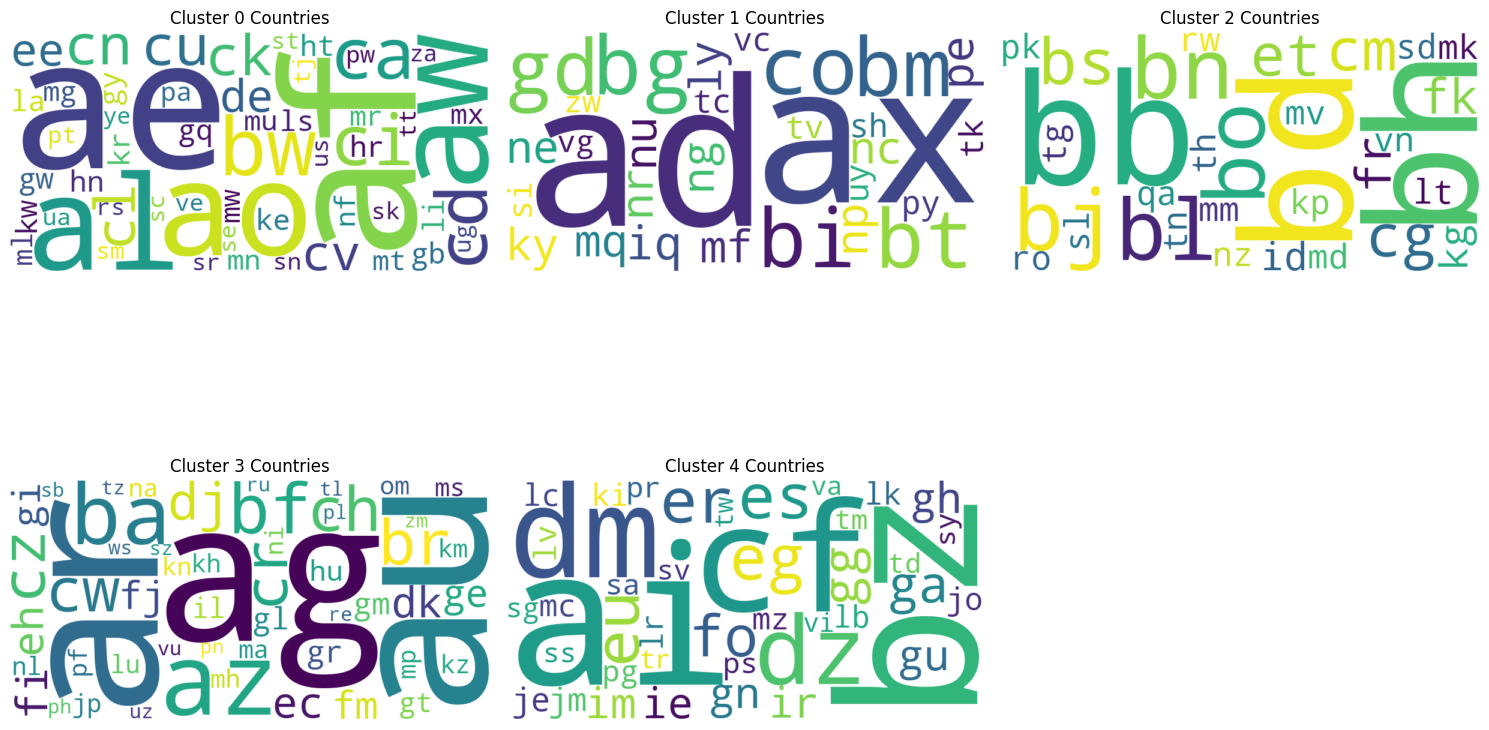


Visualization complete. Check the generated PNG files and cluster_details.txt.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the cluster data
df = pd.read_csv(r'C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_d\anthem_audio_clusters.csv')

# Cluster distribution bar plot
plt.figure(figsize=(10, 6))
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.title('Distribution of Countries Across Anthem Audio Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Countries')
plt.tight_layout()
plt.show()
plt.savefig('cluster_distribution_bar.png')
plt.close()

# Pie chart of cluster composition
plt.figure(figsize=(10, 8))
plt.pie(cluster_counts, labels=[f'Cluster {i}' for i in cluster_counts.index], 
        autopct='%1.1f%%')
plt.title('Proportion of Countries in Each Anthem Audio Cluster')
plt.tight_layout()
plt.show()
plt.savefig('cluster_distribution_pie.png')
plt.close()

# Detailed cluster analysis
print("Cluster Analysis:")
for cluster in sorted(df['Cluster'].unique()):
    countries_in_cluster = df[df['Cluster'] == cluster]['Country'].tolist()
    print(f"\nCluster {cluster} ({len(countries_in_cluster)} countries):")
    print(", ".join(countries_in_cluster[:10]) + 
          ("..." if len(countries_in_cluster) > 10 else ""))

# Create a text file with detailed cluster information
with open('cluster_details.txt', 'w') as f:
    f.write("Detailed Anthem Audio Cluster Analysis\n")
    f.write("=====================================\n\n")
    for cluster in sorted(df['Cluster'].unique()):
        countries_in_cluster = df[df['Cluster'] == cluster]['Country'].tolist()
        f.write(f"Cluster {cluster} ({len(countries_in_cluster)} countries):\n")
        f.write(", ".join(countries_in_cluster) + "\n\n")

try:
    from wordcloud import WordCloud
    
    plt.figure(figsize=(15, 10))
    for i, cluster in enumerate(sorted(df['Cluster'].unique()), 1):
        plt.subplot(2, 3, i)
        countries_in_cluster = df[df['Cluster'] == cluster]['Country'].tolist()
        wordcloud = WordCloud(width=800, height=400, 
                               background_color='white').generate(" ".join(countries_in_cluster))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {cluster} Countries')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('cluster_wordcloud.png')
    plt.close()
except ImportError:
    print("WordCloud library not installed. Skipping word cloud visualization.")

print("\nVisualization complete. Check the generated PNG files and cluster_details.txt.")

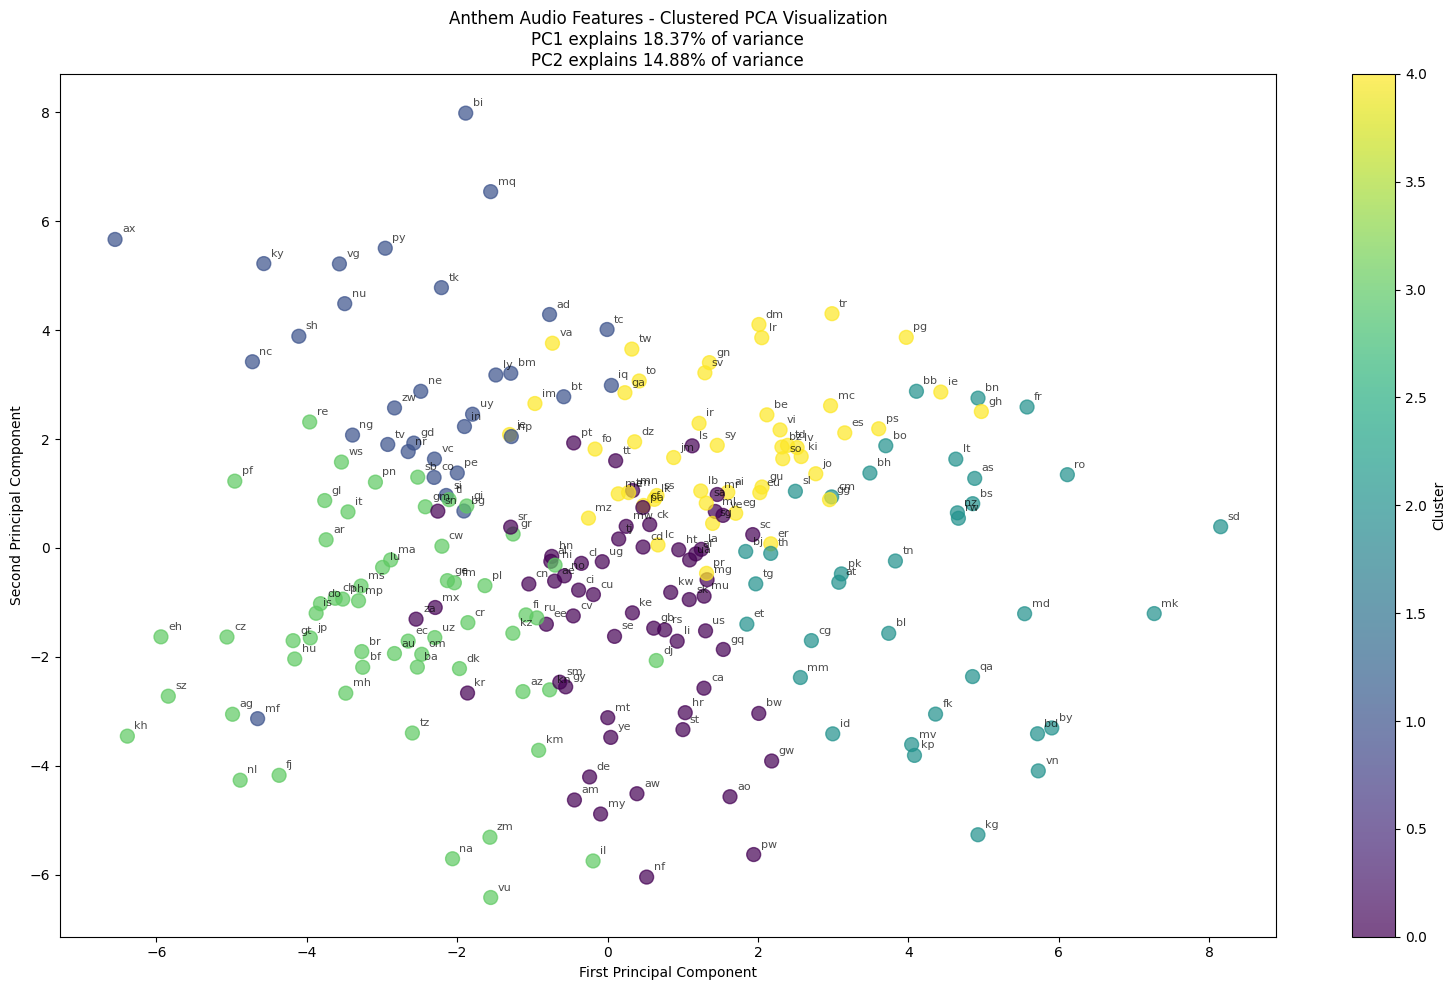

Cluster scatter plot has been saved to 'anthem_clusters_pca_scatter.png'

Cluster Composition:

Cluster 0 (60 countries):
ae, af, al, am, ao, aw, bw, ca, cd, ci, ck, cl, cn, cu, cv, de, ee, gb, gq, gw, gy, hn, hr, ht, ke, kr, kw, la, li, ls, mg, ml, mn, mr, mt, mu, mw, mx, my, nf, no, pa, pt, pw, rs, sc, se, sk, sm, sn, sr, st, tj, tt, ua, ug, us, ve, ye, za

Cluster 1 (31 countries):
ad, ax, bg, bi, bm, bt, co, gd, in, iq, ky, ly, mf, mq, nc, ne, ng, np, nr, nu, pe, py, sh, si, tc, tk, tv, uy, vc, vg, zw

Cluster 2 (35 countries):
as, at, bb, bd, bh, bj, bl, bn, bo, bs, by, cg, cm, et, fk, fr, id, kg, kp, lt, md, mk, mm, mv, nz, pk, qa, ro, rw, sd, sl, tg, th, tn, vn

Cluster 3 (57 countries):
ag, ar, au, az, ba, bf, br, ch, cr, cw, cz, dj, dk, do, ec, eh, fi, fj, fm, ge, gi, gl, gm, gr, gt, hu, il, is, it, jp, kh, km, kn, kz, lu, ma, mh, mp, ms, na, ni, nl, om, pf, ph, pl, pn, re, ru, sb, sz, tl, tz, uz, vu, ws, zm

Cluster 4 (47 countries):
ai, be, bz, cf, dm, dz, eg, er, es, eu, fo

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_anthem_clusters():
    # Load audio features
    audio_features = pd.read_csv(r'C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_d\anthem_audio_features.csv', index_col=0)
    
    # Load cluster assignments
    clusters_df = pd.read_csv(r'C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_d\anthem_audio_clusters.csv')
    
    # Normalize the features
    scaler = StandardScaler()
    audio_features_scaled = scaler.fit_transform(audio_features)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(audio_features_scaled)
    
    # Create a DataFrame with PCA results and cluster assignments
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Country'] = audio_features.index
    pca_df['Cluster'] = clusters_df['Cluster']
    
    # Plotting
    plt.figure(figsize=(16, 10))
    
    # Create a scatter plot with different colors for each cluster
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                          c=pca_df['Cluster'], 
                          cmap='viridis', 
                          alpha=0.7, 
                          s=100)
    
    # Add a colorbar
    plt.colorbar(scatter, label='Cluster')
    
    # Add country labels
    for idx, row in pca_df.iterrows():
        plt.annotate(row['Country'], 
                     (row['PC1'], row['PC2']), 
                     xytext=(5, 5),
                     textcoords='offset points', 
                     fontsize=8, 
                     alpha=0.7)
    
    plt.title('Anthem Audio Features - Clustered PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Add variance explanation
    variance_ratio = pca.explained_variance_ratio_
    plt.title(f'Anthem Audio Features - Clustered PCA Visualization\n'
              f'PC1 explains {variance_ratio[0]*100:.2f}% of variance\n'
              f'PC2 explains {variance_ratio[1]*100:.2f}% of variance')
    
    # Tight layout and save
    plt.tight_layout()
    plt.show()
    plt.savefig('anthem_clusters_pca_scatter.png', dpi=300)
    plt.close()
    
    print("Cluster scatter plot has been saved to 'anthem_clusters_pca_scatter.png'")
    
    # Print out cluster details
    print("\nCluster Composition:")
    for cluster in sorted(pca_df['Cluster'].unique()):
        cluster_countries = pca_df[pca_df['Cluster'] == cluster]['Country'].tolist()
        print(f"\nCluster {cluster} ({len(cluster_countries)} countries):")
        print(", ".join(cluster_countries))

# Two-letter code to full country name mapping
country_names = {
    'ad': 'Andorra', 'ae': 'United Arab Emirates', 'af': 'Afghanistan', 
    'ag': 'Antigua and Barbuda', 'al': 'Albania', 'am': 'Armenia', 
    'ao': 'Angola', 'ar': 'Argentina', 'at': 'Austria', 'au': 'Australia', 
    'az': 'Azerbaijan', 'ba': 'Bosnia and Herzegovina', 'bb': 'Barbados', 
    'bd': 'Bangladesh', 'be': 'Belgium', 'bf': 'Burkina Faso', 
    'bg': 'Bulgaria', 'bh': 'Bahrain', 'bi': 'Burundi', 'bj': 'Benin', 
    'bn': 'Brunei', 'bo': 'Bolivia', 'br': 'Brazil', 'bs': 'Bahamas', 
    'bt': 'Bhutan', 'bw': 'Botswana', 'by': 'Belarus', 'bz': 'Belize', 
    'ca': 'Canada', 'cd': 'Democratic Republic of the Congo', 
    'cf': 'Central African Republic', 'cg': 'Republic of the Congo', 
    'ch': 'Switzerland', 'ci': 'Ivory Coast', 'cl': 'Chile', 
    'cm': 'Cameroon', 'cn': 'China', 'co': 'Colombia', 'cr': 'Costa Rica', 
    'cu': 'Cuba', 'cv': 'Cape Verde', 'cy': 'Cyprus', 'cz': 'Czech Republic', 
    'de': 'Germany', 'dj': 'Djibouti', 'dk': 'Denmark', 'dm': 'Dominica', 
    'do': 'Dominican Republic', 'dz': 'Algeria', 'ec': 'Ecuador', 
    'ee': 'Estonia', 'eg': 'Egypt', 'er': 'Eritrea', 'es': 'Spain', 
    'et': 'Ethiopia', 'fi': 'Finland', 'fj': 'Fiji', 
    'fm': 'Micronesia', 'fr': 'France', 'ga': 'Gabon', 
    'gb': 'United Kingdom', 'gd': 'Grenada', 'ge': 'Georgia', 
    'gh': 'Ghana', 'gm': 'Gambia', 'gn': 'Guinea', 
    'gq': 'Equatorial Guinea', 'gr': 'Greece', 'gt': 'Guatemala', 
    'gw': 'Guinea-Bissau', 'gy': 'Guyana', 'hn': 'Honduras', 
    'hr': 'Croatia', 'ht': 'Haiti', 'hu': 'Hungary', 'id': 'Indonesia', 
    'ie': 'Ireland', 'il': 'Israel', 'in': 'India', 'iq': 'Iraq', 
    'ir': 'Iran', 'is': 'Iceland', 'it': 'Italy', 'jm': 'Jamaica', 
    'jo': 'Jordan', 'jp': 'Japan', 'ke': 'Kenya', 'kg': 'Kyrgyzstan', 
    'kh': 'Cambodia', 'ki': 'Kiribati', 'km': 'Comoros', 
    'kn': 'Saint Kitts and Nevis', 'kp': 'North Korea', 'kr': 'South Korea', 
    'kw': 'Kuwait', 'kz': 'Kazakhstan', 'la': 'Laos', 'lb': 'Lebanon', 
    'lc': 'Saint Lucia', 'li': 'Liechtenstein', 'lk': 'Sri Lanka', 
    'lr': 'Liberia', 'ls': 'Lesotho', 'lt': 'Lithuania', 'lu': 'Luxembourg', 
    'lv': 'Latvia', 'ly': 'Libya', 'ma': 'Morocco', 'mc': 'Monaco', 
    'md': 'Moldova', 'me': 'Montenegro', 'mg': 'Madagascar', 
    'mh': 'Marshall Islands', 'mk': 'North Macedonia', 'ml': 'Mali', 
    'mm': 'Myanmar', 'mn': 'Mongolia', 'mr': 'Mauritania', 'mt': 'Malta', 
    'mu': 'Mauritius', 'mv': 'Maldives', 'mw': 'Malawi', 'mx': 'Mexico', 
    'my': 'Malaysia', 'mz': 'Mozambique', 'na': 'Namibia', 'ne': 'Niger', 
    'ng': 'Nigeria', 'ni': 'Nicaragua', 'nl': 'Netherlands', 'no': 'Norway', 
    'np': 'Nepal', 'nr': 'Nauru', 'nz': 'New Zealand', 'om': 'Oman', 
    'pa': 'Panama', 'pe': 'Peru', 'pg': 'Papua New Guinea', 'ph': 'Philippines', 
    'pk': 'Pakistan', 'pl': 'Poland', 'pt': 'Portugal', 'pw': 'Palau', 
    'py': 'Paraguay', 'qa': 'Qatar', 'ro': 'Romania', 'rs': 'Serbia', 
    'ru': 'Russia', 'rw': 'Rwanda', 'sa': 'Saudi Arabia', 
    'sb': 'Solomon Islands', 'sc': 'Seychelles', 'sd': 'Sudan', 
    'se': 'Sweden', 'sg': 'Singapore', 'si': 'Slovenia', 'sk': 'Slovakia', 
    'sl': 'Sierra Leone', 'sm': 'San Marino', 'sn': 'Senegal', 
    'so': 'Somalia', 'sr': 'Suriname', 'ss': 'South Sudan', 
    'st': 'São Tomé and Príncipe', 'sv': 'El Salvador', 'sy': 'Syria', 
    'sz': 'Eswatini', 'td': 'Chad', 'tg': 'Togo', 'th': 'Thailand', 
    'tj': 'Tajikistan', 'tl': 'Timor-Leste', 'tm': 'Turkmenistan', 
    'tn': 'Tunisia', 'to': 'Tonga', 'tr': 'Turkey', 'tt': 'Trinidad and Tobago', 
    'tv': 'Tuvalu', 'tz': 'Tanzania', 'ua': 'Ukraine', 'ug': 'Uganda', 
    'us': 'United States', 'uy': 'Uruguay', 'uz': 'Uzbekistan', 
    'vc': 'Saint Vincent and the Grenadines', 've': 'Venezuela', 
    'vn': 'Vietnam', 'vu': 'Vanuatu', 'ws': 'Samoa', 'ye': 'Yemen', 
    'za': 'South Africa', 'zm': 'Zambia', 'zw': 'Zimbabwe'
}

# Main execution
if __name__ == '__main__':
    plot_anthem_clusters()